In [1]:
from pathlib import Path

# The run scripts make Google Benchmark write JSON results to `benchmark_output/`.
# That directory is gitignored so that it exists but your results won't get committed accidentally.
benchmark_dir = Path(f"benchmark_outputs")
system_description = ""

if len(list(benchmark_dir.iterdir())) <= 1:
    # No local-machine runs, use the provided data
    benchmark_dir = Path(f"benchmark_outputs_example")
    system_description = "8-Core Apple M1 Pro Laptop"


save_images_used_in_readme = False
figure_show_mode = 'svg' # 'svg' is inline and visible in GitHub, None is native interactive plotly plots that are not visible in GitHub and several MB in size

In [2]:
def format_bytes(f: int):
    mags = {
        "B": 0,
        "KiB": 2**10,
        "MiB": 2**20,
        "GiB": 2**30,
        "TiB": 2**40,
    }
    best_unit = "B"
    for unit, multiplier in mags.items():
        if mags[best_unit] <= multiplier <= f:
            best_unit = unit

    value = f if mags[best_unit] == 0 else f/mags[best_unit]
    return f"{value:0.2g} {best_unit}"

def parse_float_with_magnitude(f: str):
    mags = {
        "K": 10**3,
        "k": 10**3,
        "M": 10**6,
        "G": 10**9,
        "T": 10**12,
    }
    mag = mags.get(f[-1], 1)
    if mag != 1:
        f = f[:-1]
    return float(f) * mag


def google_benchmark_output_to_list(path: Path):
    import json

    everything = json.loads(path.read_text())


    # parse out interesting information
    for row in everything["benchmarks"]:
        bench = row["name"]
        i = bench.find("/")
        if i > 0:
            row["Group"] = bench[0:i]
            row["Variant"] = bench[i+1:]
        else:
            row["Group"] = bench

        row["Benchmark"] = bench
        del row["name"]

        if not row.get("Variant"):
            row["Variant"] = row["Benchmark"]

        row["Language"] = path.stem
    return everything["benchmarks"]

In [3]:
import pandas as pd
import plotly.express as px

benchmarks = []
for benchmark_output_file in benchmark_dir.glob("*.json"):
    benchmarks.extend(google_benchmark_output_to_list(benchmark_output_file))

df = pd.DataFrame(benchmarks)
df.sort_values(by=['Language', 'bytes_per_second'], ascending=True, inplace=True)

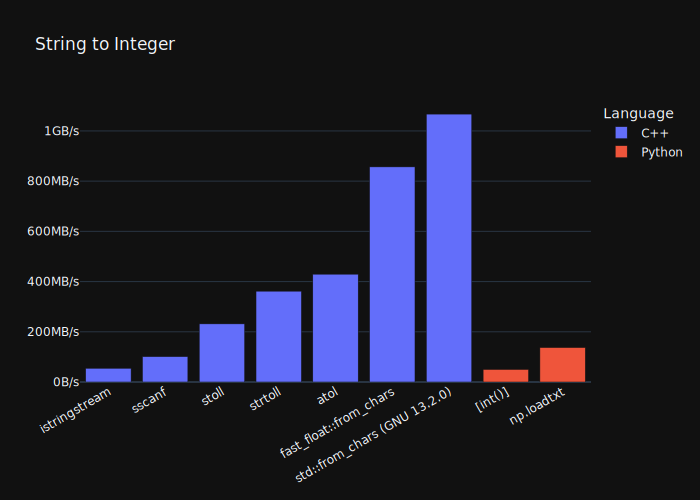

In [4]:
fig = px.bar(df[df.Group=="IntFieldParse"], x='Variant', y='bytes_per_second', title="String to Integer", color="Language")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        tickformat = '~s',
    ),
    xaxis = dict(title=None, tickangle=-30)
)
fig.show(figure_show_mode)
if save_images_used_in_readme:
    fig.write_image("string-to-integer.svg")

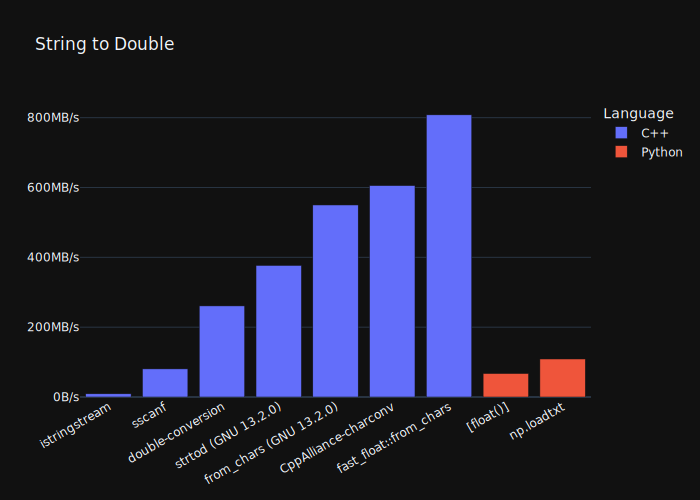

In [5]:
fig = px.bar(df[df.Group=="DoubleFieldParse"], x='Variant', y='bytes_per_second', title="String to Double", color="Language")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        tickformat = '~s',
    ),
    xaxis = dict(title=None, tickangle=-30)
)
fig.show(figure_show_mode)
if save_images_used_in_readme:
    fig.write_image("string-to-double.svg")

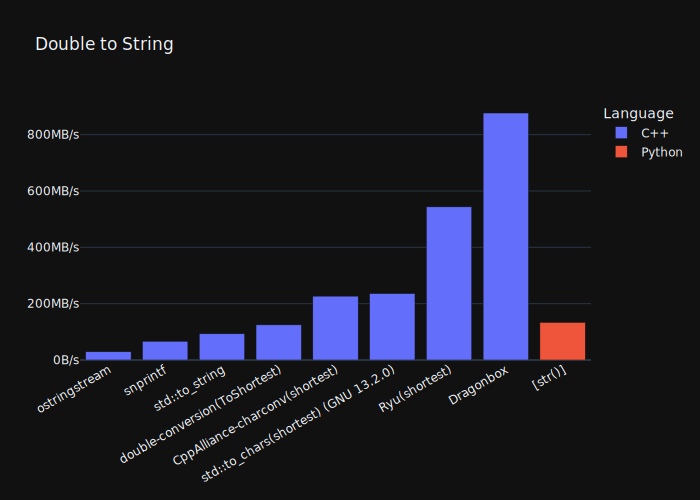

In [6]:
fig = px.bar(df[df.Group=="DoubleFieldFormat"], x='Variant', y='bytes_per_second', title="Double to String", color="Language")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        tickformat = '~s',
    ),
    xaxis = dict(title=None, tickangle=-30)
)
fig.show(figure_show_mode)
if save_images_used_in_readme:
    fig.write_image("double-to-string.svg")

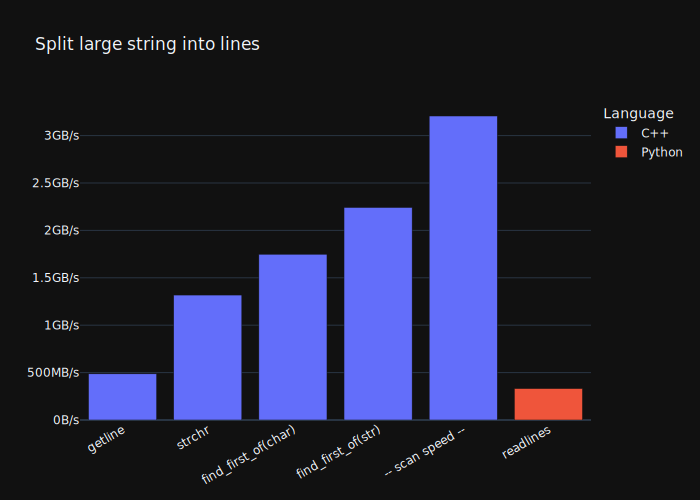

In [7]:
data = df[df["Group"].isin(["ScanSpeed", "SplitLines"])].copy()
# scan speed is not a line split method but offers context for how fast the best possible
# method could be (i.e. a roofline)
data.replace("ScanSpeed", "-- scan speed --", inplace=True)

fig = px.bar(data, x='Variant', y='bytes_per_second', title="Split large string into lines", color="Language")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        tickformat = '~s'
    ),
    xaxis = dict(title=None, tickangle=-30)
)
fig.show(figure_show_mode)


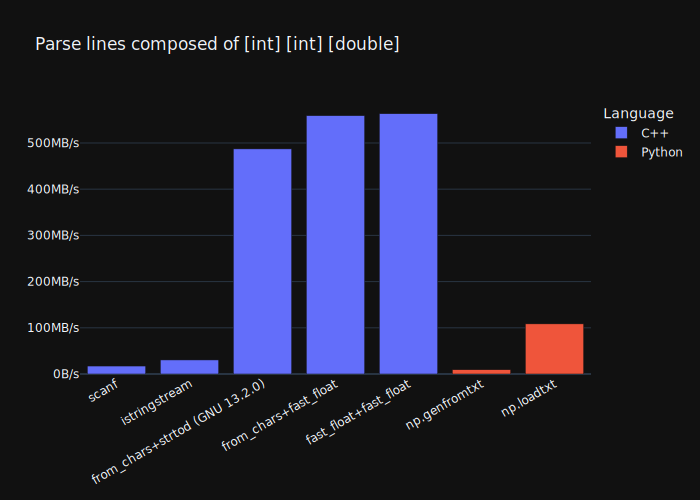

In [8]:
data = df[df["Group"].isin(["BlockParse"])]

fig = px.bar(data, x='Variant', y='bytes_per_second', title="Parse lines composed of [int] [int] [double]", color="Language")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        tickformat = '~s',
    ),
    xaxis = dict(title=None, tickangle=-30)
)
fig.show(figure_show_mode)

In [9]:
pardata = df[df["Group"].isin(["BlockParseParallel"])].copy()
pardata["ParVariant"] = pardata["Variant"].str.split("/").str[0]
pardata["ChunkSizeInt"] = pardata["Variant"].str.split("/").str[3].astype(int)
pardata["ChunkSize"] = pardata["ChunkSizeInt"].transform(format_bytes)

pardata.sort_values(by=['ParVariant', 'p', 'ChunkSizeInt'], ascending=[True, True, False], inplace=True)

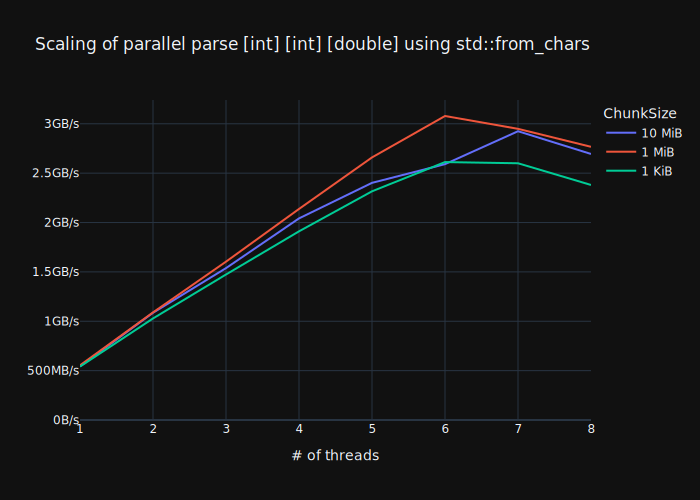

In [10]:
data = pardata[pardata["ParVariant"].isin(["from_chars+fast_float"])]

fig = px.line(data, x='p', y='bytes_per_second', title="Scaling of parallel parse [int] [int] [double] using std::from_chars", color="ChunkSize")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        rangemode = 'tozero',
        tickformat = '~s'
    ),
    xaxis = dict(title='# of threads')
)
fig.show(figure_show_mode)

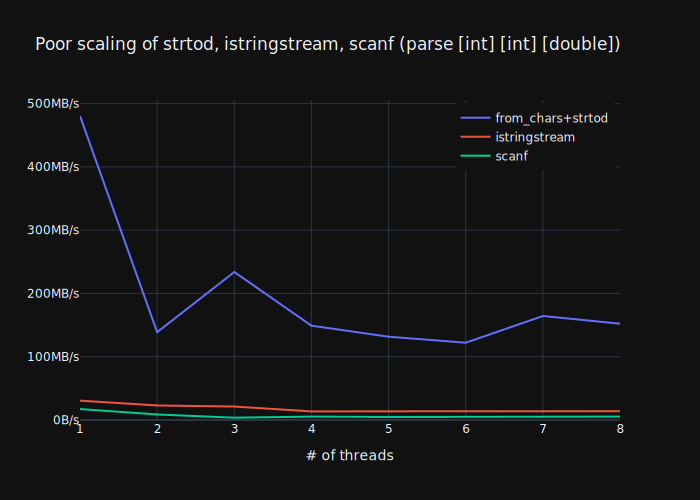

In [11]:
data = pardata[pardata["ParVariant"].isin(["from_chars+strtod", 'istringstream', 'scanf'])]

fig = px.line(data, x='p', y='bytes_per_second', title="Poor scaling of strtod, istringstream, scanf (parse [int] [int] [double])", color="ParVariant")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        rangemode = 'tozero',
        tickformat = '~s'
    ),
    xaxis = dict(title='# of threads'),
        legend=dict(
        title=None,
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
)
fig.show(figure_show_mode)

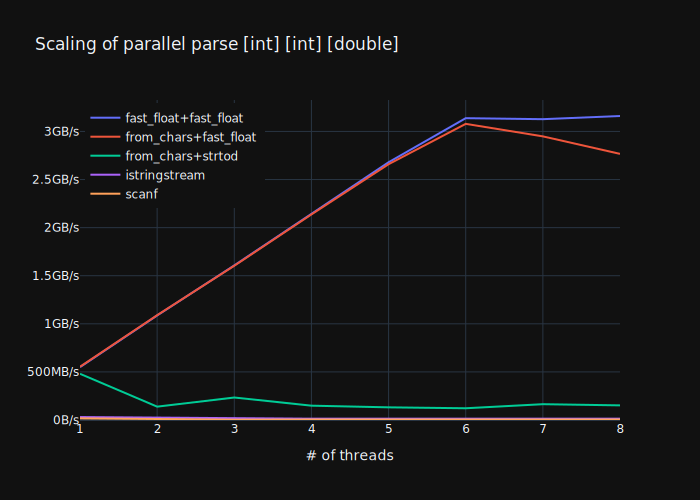

In [12]:
data = pardata[pardata["ParVariant"].isin(["fast_float+fast_float", "from_chars+fast_float", "from_chars+strtod", 'istringstream', 'scanf'])]
data = data[data["ChunkSize"].isin(["1 MiB"])]

fig = px.line(data, x='p', y='bytes_per_second', title="Scaling of parallel parse [int] [int] [double]", color="ParVariant")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        rangemode = 'tozero',
        tickformat = '~s'
    ),
    xaxis = dict(title='# of threads'),
    legend=dict(
        title=None,
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
)
fig.show(figure_show_mode)
if save_images_used_in_readme:
    fig.write_image("parallel-parse-scaling.svg")